In [2]:
# Install required libraries
!pip install praw nltk textblob sumy python-louvain wordcloud gensim transformers

# Importing necessary libraries
import logging

# Set logging level to suppress PRAW warning messages
logging.getLogger("praw").setLevel(logging.WARNING)
logging.getLogger("praw").setLevel(logging.ERROR)

# Importing NLTK for natural language processing tasks
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Importing regular expressions for text processing
import re

# Importing PRAW for accessing Reddit API
import praw

# Importing data manipulation libraries
import pandas as pd
import numpy as np

# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# Importing network analysis libraries
import networkx as nx
from collections import Counter
import ast

# Importing text analysis libraries
from textblob import TextBlob
from wordcloud import WordCloud

# Importing machine learning libraries
from sklearn.feature_extraction.text import TfidfVectorizer

# Importing community detection libraries
from concurrent.futures import ProcessPoolExecutor
import community as community_louvain

# Importing Gensim for topic modeling
from gensim import corpora, models
from pprint import pprint

# Importing additional NLTK libraries for text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Importing transformers library for NLP tasks
from transformers import pipeline

# Importing Sumy for text summarization
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Reddit API credentials
reddit_client_id = 'bLfHRgL3R8y69_QUj7xMrA'
reddit_client_secret = 'HO0fvx3tIbnujuyCqIPmjXT9lopiCg'
reddit_user_agent = 'CommunicationTop2560'

# Initialize Reddit API
reddit = praw.Reddit(client_id=reddit_client_id,
                     client_secret=reddit_client_secret,
                     user_agent=reddit_user_agent)

# Subreddit to follow
subreddit_name = 'gadgets'
subreddit = reddit.subreddit(subreddit_name)

# Extracting data from the subreddit
posts = []

# Loop through the top posts of the year in the specified subreddit
for submission in subreddit.top('year', limit=1000):
    # Collect relevant information from each post
    posts.append({
        'ID': submission.id,
        'Title': submission.title,
        'Num_comments': submission.num_comments,
        'Author': str(submission.author),
    })

# Create a DataFrame from the extracted data
df = pd.DataFrame(posts)

# Save the DataFrame to a CSV file (commented out)
# df.to_csv('gadgets_data.csv', index=False)

# Display the DataFrame
df

# Extracting comments from posts with titles containing 'iphone'
filtered_posts = df[df['Title'].str.contains('iphone', case=False, regex=True)]
selected_post_ids = filtered_posts['ID'].tolist()

# Collect data from comments on iPhone-related posts
iphone_comments_data = []

# Loop through the selected posts and extract comments
for post_id in selected_post_ids:
    try:
        post = reddit.submission(id=post_id)
        post_title = df[df['ID'] == post_id]['Title'].values[0]
        comments = post.comments.list()

        # Extracting more information from comments
        for comment in comments:
            if isinstance(comment, praw.models.MoreComments):
                continue  # Skip 'MoreComments' objects
            iphone_comments_data.append({
                'Post_ID': post_id,
                'Title': post_title,
                'Comment': comment.body,
                'Author': str(comment.author),
                'Upvote_ratio': post.upvote_ratio,
                'Score': post.score,
                'Subreddit': post.subreddit.display_name,
                'Selftext': post.selftext,
                'Upvotes': post.ups,
            })
    except Exception as e:
        print(f"Error processing post {post_id}: {str(e)}")

# Create a DataFrame from the extracted iPhone comments data
iphone_comments_df = pd.DataFrame(iphone_comments_data)

# Remove NaN values and 'None' authors
iphone_comments_df = iphone_comments_df[iphone_comments_df['Author'].notna() & (iphone_comments_df['Author'] != 'None')]
iphone_comments_df


Post_ID                                              Title  \
0      11283q1  50% rejection rate for iPhone casings produced...   
1      11283q1  50% rejection rate for iPhone casings produced...   
2      11283q1  50% rejection rate for iPhone casings produced...   
3      11283q1  50% rejection rate for iPhone casings produced...   
4      11283q1  50% rejection rate for iPhone casings produced...   
...        ...                                                ...   
30145  11e67uz  iPhone 16 Pro Still on Track to Feature Under-...   
30146  11e67uz  iPhone 16 Pro Still on Track to Feature Under-...   
30147  11e67uz  iPhone 16 Pro Still on Track to Feature Under-...   
30148  11e67uz  iPhone 16 Pro Still on Track to Feature Under-...   
30149  11e67uz  iPhone 16 Pro Still on Track to Feature Under-...   

                                                 Comment           Author  \
0      Atleast the quality control is still there ins...     sonbarington   
1      Chinese manufacturers can make you anything yo...        55_peters   
2      I know many people who have managed remote sof...  EmperorOfCanada   
3      This will always be the problem with shipping ...     bitwarrior80   
4      I wonder what the rejection rate was in China ...     Sethmeisterg   
...                                                  ...              ...   
30145  I loved the button/sensor on the back of by g6...           Datkif   
30146  With deepfakes, I would worry about voice ID\n...     What-a-Crock   
30147               Doesn’t FaceId have a mask mode now?       SmurphsLaw   
30148  Yeah I had it on my s8. Super fast and the pla...  snozzcumbersoup   
30149  I mean people have already been able to trick ...         DevoidHT   

       Upvote_ratio  Score Subreddit Selftext  Upvotes  
0              0.93  22658   gadgets             22658  
1              0.93  22658   gadgets             22658  
2              0.93  22658   gadgets             22658  
3              0.93  22658   gadgets             22658  
4              0.93  22658   gadgets             22658  
...             ...    ...       ...      ...      ...  
30145          0.80    145   gadgets               145  
30146          0.80    145   gadgets               145  
30147          0.80    145   gadgets               145  
30148          0.80    145   gadgets               145  
30149          0.80    145   gadgets               145  

[27940 rows x 9 columns]

-	Post_ID: Unique identifier for each Reddit post.
-	Title: Post title capturing the essence of the discussion.
-	Comment: Insights and opinions shared by users in the comments section.
-	Author: Reddit username of the individual contributing to the discussion.
-	Upvote_ratio: Ratio of upvotes to total votes, indicating community approval.
-	Score: Cumulative score reflecting the post's popularity and impact.
-	Upvotes: Number of upvotes received by the post.
-	Text: Full text of the post.
-	Tokens: Tokenized representation of the post for analysis.
-	Sentiment: Numeric sentiment score reflecting the emotional tone of the post.
-	Sentiment_Category: Categorization of sentiment as Positive, Negative, or Neutral.
-	Processed_Text: Text after preprocessing, ready for advanced analysis.



In [4]:
# Combine Title and Selftext for text analysis
iphone_comments_df['Text'] = iphone_comments_df['Title'] + ' ' + iphone_comments_df['Comment'] + ' ' + iphone_comments_df['Selftext']

# Tokenize and clean the text
stop_words = set(stopwords.words('english'))
# Tokenize the combined text into words
iphone_comments_df['Tokens'] = iphone_comments_df['Text'].apply(lambda x: word_tokenize(re.sub(r'[^a-zA-Z0-9]', ' ', str(x).lower())))
# Remove non-alphanumeric characters, convert to lowercase, and remove stopwords
iphone_comments_df['Tokens'] = iphone_comments_df['Tokens'].apply(lambda x: [word for word in x if word.isalnum() and word not in stop_words])

# Flatten the list of tokens
all_tokens = [token for sublist in iphone_comments_df['Tokens'].tolist() for token in sublist]
token_series = pd.Series(all_tokens)
token_counts = token_series.value_counts()

# Function to further filter tokens
def filter_tokens(tokens):
    return [token for token in tokens if token.isalpha() and len(token) > 2]

# Apply the function to each row in the 'Tokens' column
iphone_comments_df['Tokens'] = iphone_comments_df['Tokens'].apply(filter_tokens)

# Identify keywords and hashtags using frequency distribution
fdist = FreqDist(all_tokens)
# Extract keywords based on frequency distribution
keywords = [word for word, freq in fdist.most_common(20) if len(word) > 2]

# Identify influencers (top authors)
# Extract the top 5 authors based on the number of comments
top_authors = iphone_comments_df['Author'].value_counts().index[:5].tolist()

# Identify different groups (subreddits)
# Extract unique subreddits from the 'Subreddit' column
different_groups = iphone_comments_df['Subreddit'].unique().tolist()

# Display the results
print("Keywords and Hashtags:", keywords)
print("\nTop Influencers:", top_authors)
print("\nDifferent Groups (Subreddits):", different_groups)


Keywords and Hashtags: ['iphone', 'apple', 'pro', 'usb', 'new', 'phone', 'iphones', 'like', 'people', 'charging', 'max', 'battery', 'port', 'year', 'get', 'use', 'would', 'years']

Top Influencers: ['nicuramar', 'SUPRVLLAN', 'Sylvurphlame', 'Pubelication', 'Deep90']

Different Groups (Subreddits): ['gadgets']


'nicuramar', 'SUPRVLLAN', 'Sylvurphlame', 'Pubelication', 'Deep90': Engaging with these influencers could be a strategic move for any campaign or promotional activity by Apple or third-party accessory manufacturers. Their content likely sways public opinion and consumer decisions.


'gadgets': Subscribers to this subreddit are probably tech-savvy users who are interested in the latest technological innovations, updates, and gadget reviews. This group would be particularly responsive to new releases, updates, and technical improvements in iPhones.


In [5]:
# Define columns to drop from the DataFrame
columns_to_drop = ['Subreddit', 'Selftext']

# Drop the specified columns from the DataFrame
iphone_comments_df = iphone_comments_df.drop(columns=columns_to_drop)
iphone_comments_df

# Create a graph (network) using NetworkX
G = nx.Graph()

# Add nodes and edges based on the dataset
for _, row in iphone_comments_df.iterrows():
    author = row['Author']
    title = row['Title']
    # Add a node for each author
    if author not in G:
        G.add_node(author)
    # Add edges between this author and others who commented on the same post
    authors_in_same_post = iphone_comments_df[iphone_comments_df['Title'] == title]['Author'].unique()
    for other_author in authors_in_same_post:
        if author != other_author:
            G.add_edge(author, other_author)

# Calculate degree centrality for each author
degree_centrality = nx.degree_centrality(G)

# Convert to a more readable format (e.g., DataFrame)
degree_centrality_df = pd.DataFrame(degree_centrality.items(), columns=['Author', 'Degree Centrality'])

# Display the first few rows of the centrality DataFrame
degree_centrality_df

# Find the top 10 most central authors based on degree centrality
most_central_authors_df = degree_centrality_df.sort_values(by='Degree Centrality', ascending=False).head(10)

# Display the top 10 most central authors
most_central_authors_df

# Define keywords of interest
keywords_of_interest = ['apple', 'iphone', 'iphones', 'phone']

# Filter comments that contain any of the keywords
filtered_comments = iphone_comments_df[iphone_comments_df['Tokens'].apply(lambda tokens: any(keyword in tokens for keyword in keywords_of_interest))]

# Flatten the list of tokens from the filtered comments
filtered_tokens = [token for tokens in filtered_comments['Tokens'] for token in tokens]

# Count the occurrences of each token in the filtered set
filtered_token_counts = Counter(filtered_tokens)

# Remove the keywords of interest from this count (to focus on associated words)
for keyword in keywords_of_interest:
    filtered_token_counts.pop(keyword, None)

# Get the top 45 most common tokens (excluding the keywords of interest)
top_associated_words = filtered_token_counts.most_common(45)

# Display the top associated words in a DataFrame
top_associated_words_df = pd.DataFrame(top_associated_words, columns=['Token', 'Count'])
top_associated_words_df


Token  Count
0           pro   9935
1           usb   9146
2           new   7431
3          like   4573
4        people   4364
5      charging   4047
6           max   3901
7       battery   3565
8          port   3413
9          year   3353
10          get   3209
11          use   2944
12        would   2916
13        years   2831
14          one   2818
15         even   2550
16        still   2530
17       update   2432
18        users   2397
19      android   2380
20      feature   2340
21       phones   2217
22        could   2193
23         time   2177
24       really   2023
25          way   2014
26       cables   2005
27         make   1982
28         need   1975
29        first   1875
30    lightning   1814
31       google   1801
32       switch   1743
33  accessories   1717
34          ios   1705
35       device   1696
36         also   1660
37         much   1637
38          old   1632
39        issue   1626
40        india   1621
41        think   1588
42      support   1571
43     software   1561
44        never   1558

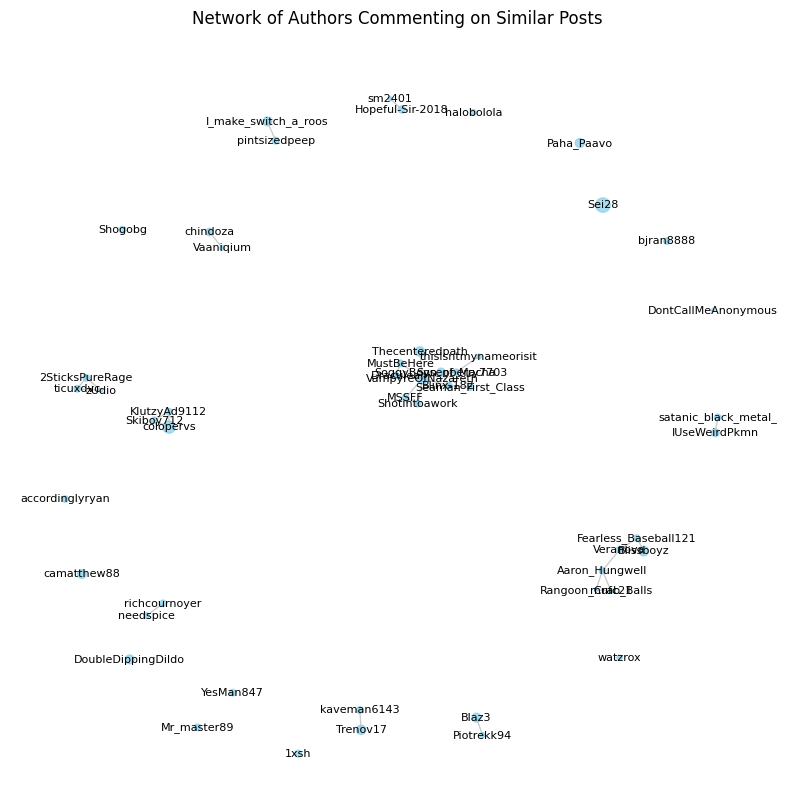

In [6]:
# Randomly sample 50 nodes from the graph
sampled_nodes = np.random.choice(list(G.nodes), size=50, replace=False)

# Create a subgraph using the sampled nodes
subgraph = G.subgraph(sampled_nodes)

# Retrieve degree centrality values for sampled nodes
subgraph_centrality = {node: degree_centrality[node] for node in sampled_nodes}

# Plot the subgraph with node sizes based on degree centrality
plt.figure(figsize=(10, 10))  # Adjusted for a reasonable size
pos = nx.spring_layout(subgraph)  # Define layout for better visualization
nx.draw_networkx_nodes(subgraph, pos, node_size=[v * 1000 for v in subgraph_centrality.values()], node_color="skyblue", alpha=0.7)
nx.draw_networkx_edges(subgraph, pos, alpha=0.2)
nx.draw_networkx_labels(subgraph, pos, font_size=8)
plt.title("Network of Authors Commenting on Similar Posts")
plt.axis('off')  # Hide axis for cleaner visualization
plt.show()


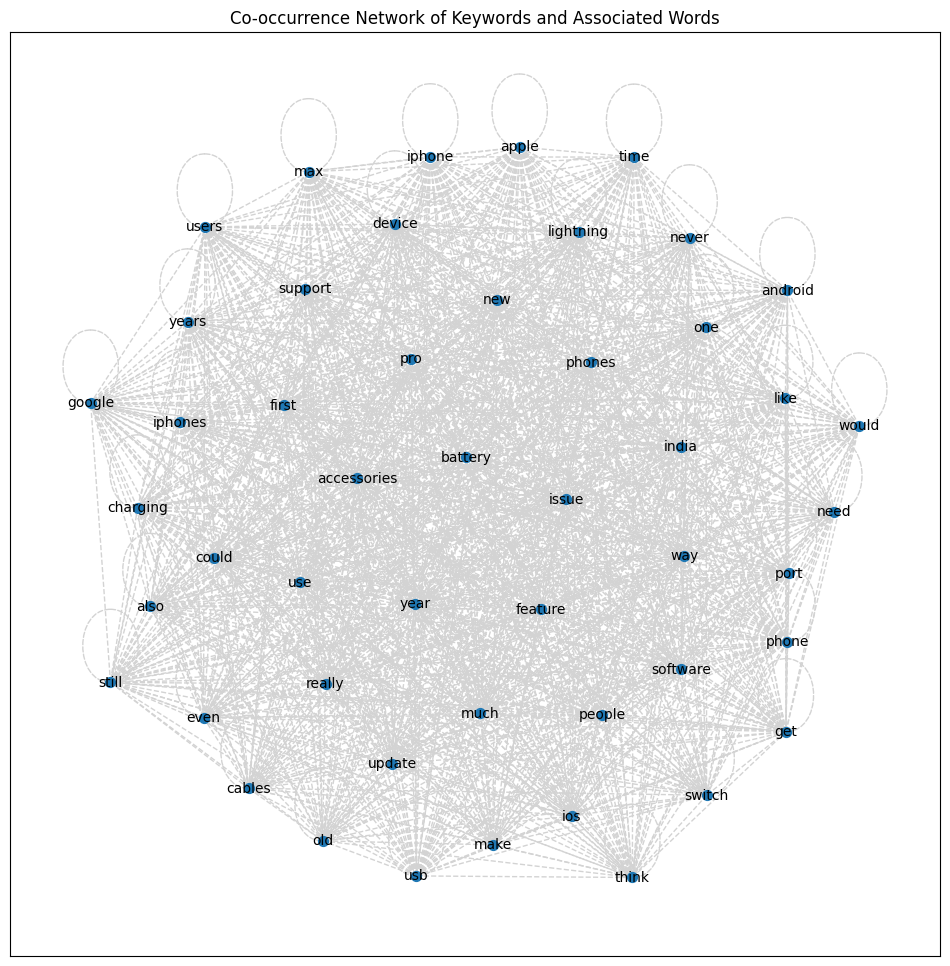

In [7]:
# Create a list of the top associated words for graph nodes
top_words = [word for word, _ in top_associated_words]

# Create an empty graph
word_graph = nx.Graph()

# Add nodes for each of the top words and the initial keywords
all_words = keywords_of_interest + top_words
word_graph.add_nodes_from(all_words)

# Add edges based on co-occurrence in the same comment
for comment_tokens in filtered_comments['Tokens']:
    # For each pair of words in the comment, add an edge if both words are in our list
    for i in range(len(comment_tokens)):
        for j in range(i + 1, len(comment_tokens)):
            if comment_tokens[i] in all_words and comment_tokens[j] in all_words:
                word_graph.add_edge(comment_tokens[i], comment_tokens[j])

# Plot the network with dashed lines in a lighter color
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(word_graph)  # Layout for the nodes

# Define edge colors and styles
edge_colors = ['lightgray' for _ in word_graph.edges()]
edge_styles = ['dashed' for _ in word_graph.edges()]

nx.draw_networkx(
    word_graph, pos, with_labels=True, node_size=50, font_size=10,
    width=1, edge_color=edge_colors, style=edge_styles
)

plt.title("Co-occurrence Network of Keywords and Associated Words")
plt.show()


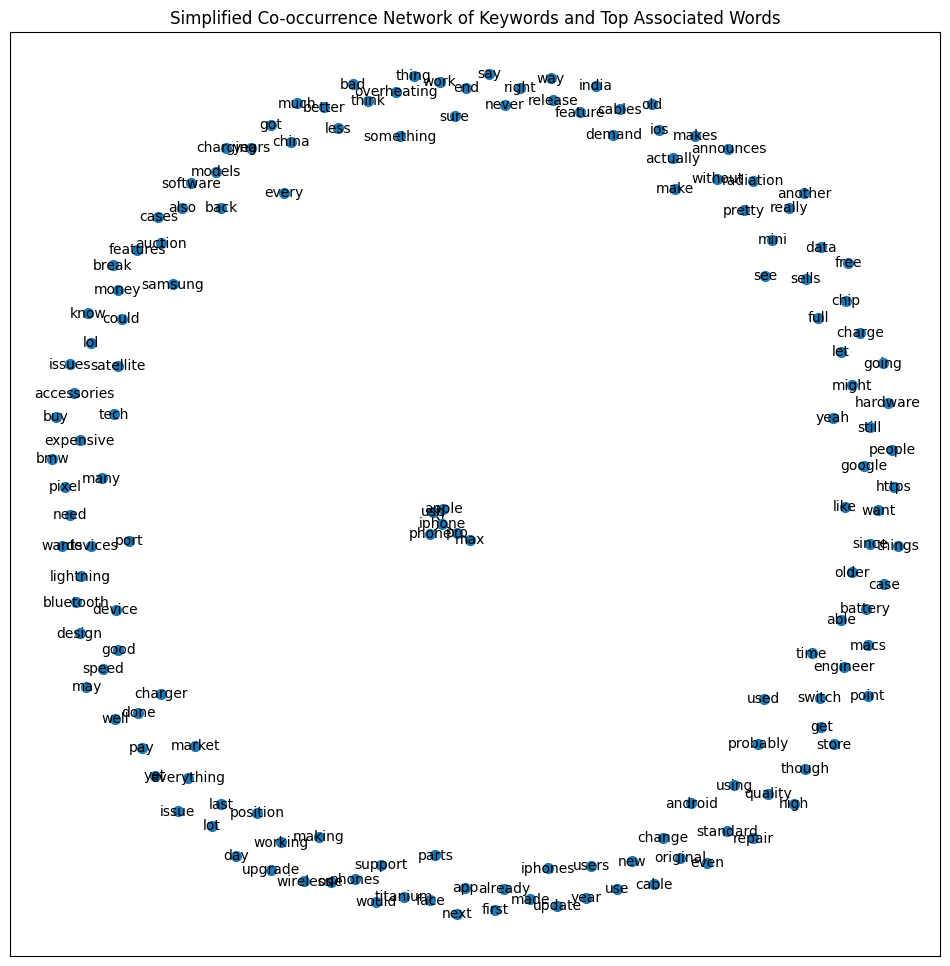

In [8]:
# Get the top 10 most common tokens (excluding the keywords of interest)
top_associated_words = filtered_token_counts.most_common(150)

# Create a list of these top associated words
top_words = [word for word, _ in top_associated_words]

# Create an empty graph
word_graph = nx.Graph()

# Add nodes for each of the top words and the initial keywords
all_words = keywords_of_interest + top_words
word_graph.add_nodes_from(all_words)

# Add edges based on co-occurrence in the same comment, but limit the number of edges
edge_count = Counter()
for comment_tokens in filtered_comments['Tokens']:
    for i in range(len(comment_tokens)):
        for j in range(i + 1, len(comment_tokens)):
            if comment_tokens[i] in all_words and comment_tokens[j] in all_words:
                edge = (comment_tokens[i], comment_tokens[j])
                edge_count[edge] += 1

# Filter to include only the top 5-10 edges
top_edges = [edge for edge, count in edge_count.most_common(10)]
for edge in top_edges:
    word_graph.add_edge(*edge)

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(word_graph) # Layout for the nodes
nx.draw_networkx(word_graph, pos, with_labels=True, node_size=50, font_size=10, width=1)
plt.title("Simplified Co-occurrence Network of Keywords and Top Associated Words")
plt.show()


- Focused Discussion: This visualization filters the network to show only terms that have at least three connections, which likely highlights the most robust and recurring themes in the conversation about the iPhone.
- 	Dense Connectivity: The strong interconnectivity around the term "iPhone" underscores its central role in the discussions. Terms that are directly connected to "iPhone" could be defining aspects of the device or the most frequently addressed concerns and features.
- 	Discussion Insights
- 	Comparative Analysis: Terms like "market," "Google," and "Android" in close proximity to "iPhone" suggest comparative discussions, potentially about market share, features, or user preferences


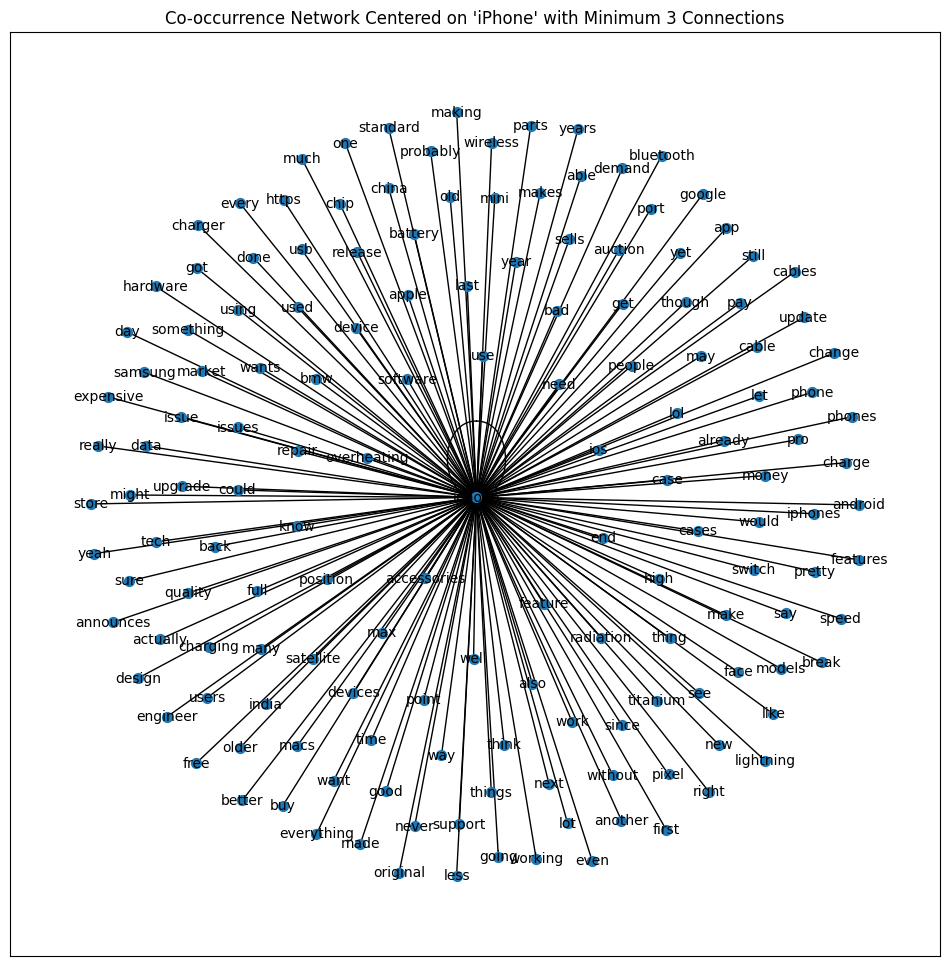

In [9]:
# Create an empty graph
word_graph = nx.Graph()

# Add the node for 'iphone'
word_graph.add_node('iphone')

# Add edges for 'iphone' based on co-occurrence, only if they co-occur at least 3 times
for comment_tokens in filtered_comments['Tokens']:
    if 'iphone' in comment_tokens:
        for token in comment_tokens:
            if token != 'iphone' and token in all_words:
                edge = ('iphone', token)
                edge_count[edge] += 1

# Filter to include only edges with at least 3 co-occurrences for 'iphone'
for edge, count in edge_count.items():
    if count >= 3 and 'iphone' in edge:
        word_graph.add_edge(*edge)

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(word_graph)  # Layout for the nodes
nx.draw_networkx(word_graph, pos, with_labels=True, node_size=50, font_size=10, width=1)
plt.title("Co-occurrence Network Centered on 'iPhone' with Minimum 3 Connections")
plt.show()

-	"iPhone": As the central node, it's the primary subject of the discussion. The proximity of other terms to "iPhone" suggests their relative importance or frequency in the conversation.
-		"Apple" and "Pro": These terms near the "iPhone" node indicate a focus on the brand and potentially the iPhone Pro models, which could be discussions around higher-end features or comparisons within the iPhone range.
-		Surrounding Keywords and Buzz
-		Hardware Components: Words like "parts," "case," "titanium," and "satellite" imply a discussion around the physical aspects of iPhones. "Titanium" may refer to build materials, and "satellite" could be related to connectivity features.
-		Functionality and Features: "Charge," "speed," "iOS," "accessories," "quality," "features," and "repair" are indicative of users discussing the functionality, software, and service aspects of the iPhone. This might include battery life, operating system functionality, the range and quality of accessories, and repairability.
-		Market and Manufacturing: Terms such as "making," "standard," "market," "original," and "engineers" suggest conversations about the iPhone's position in the market, manufacturing standards, and engineering quality.
-	Consumer Concerns: "Need," "pay," "price," and "expensive" reflect consumer sentiment around the cost and perceived value of iPhones.
-	Competition and Comparison: The presence of "Google," "Android," and comparisons with other "devices" show that discussions often compare the iPhone to its competitors, likely in terms of features, user experience, and value for money.
-		Innovation and Development: "New," "models," "design," and "features" indicate a focus on the latest developments, design choices, and feature sets in new iPhone models.
-	Durability and Materials: "Titanium" and "case" suggest that there is a conversation around the materials used in iPhones, possibly discussing their durability and premium feel.
-	Connectivity and Technology: "Port," "Bluetooth," "satellite," and "speed" point to discussions about the various connectivity options and performance aspects of the iPhone.
-	Service and Support: "Repair" and "quality" indicate concerns or commendations regarding the iPhone's build quality and the ease of getting it serviced or repaired.


In [10]:
# Sample a subset of comments for sentiment analysis
sampled_comments = iphone_comments_df['Comment'].sample(n=500, random_state=1)

# Define a function to calculate sentiment polarity using TextBlob
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis on the sampled comments
sampled_comments_sentiment = sampled_comments.apply(calculate_sentiment)

# Add a column for sentiment category based on the sentiment polarity values
sentiment_category = np.where(sampled_comments_sentiment >= 0.05, 'Positive',
                              np.where(sampled_comments_sentiment <= -0.05, 'Negative', 'Neutral'))

# Count the number of each sentiment category
sentiment_counts = pd.value_counts(sentiment_category)

# Display sentiment counts
print(sentiment_counts)

Positive    211
Neutral     185
Negative    104
dtype: int64


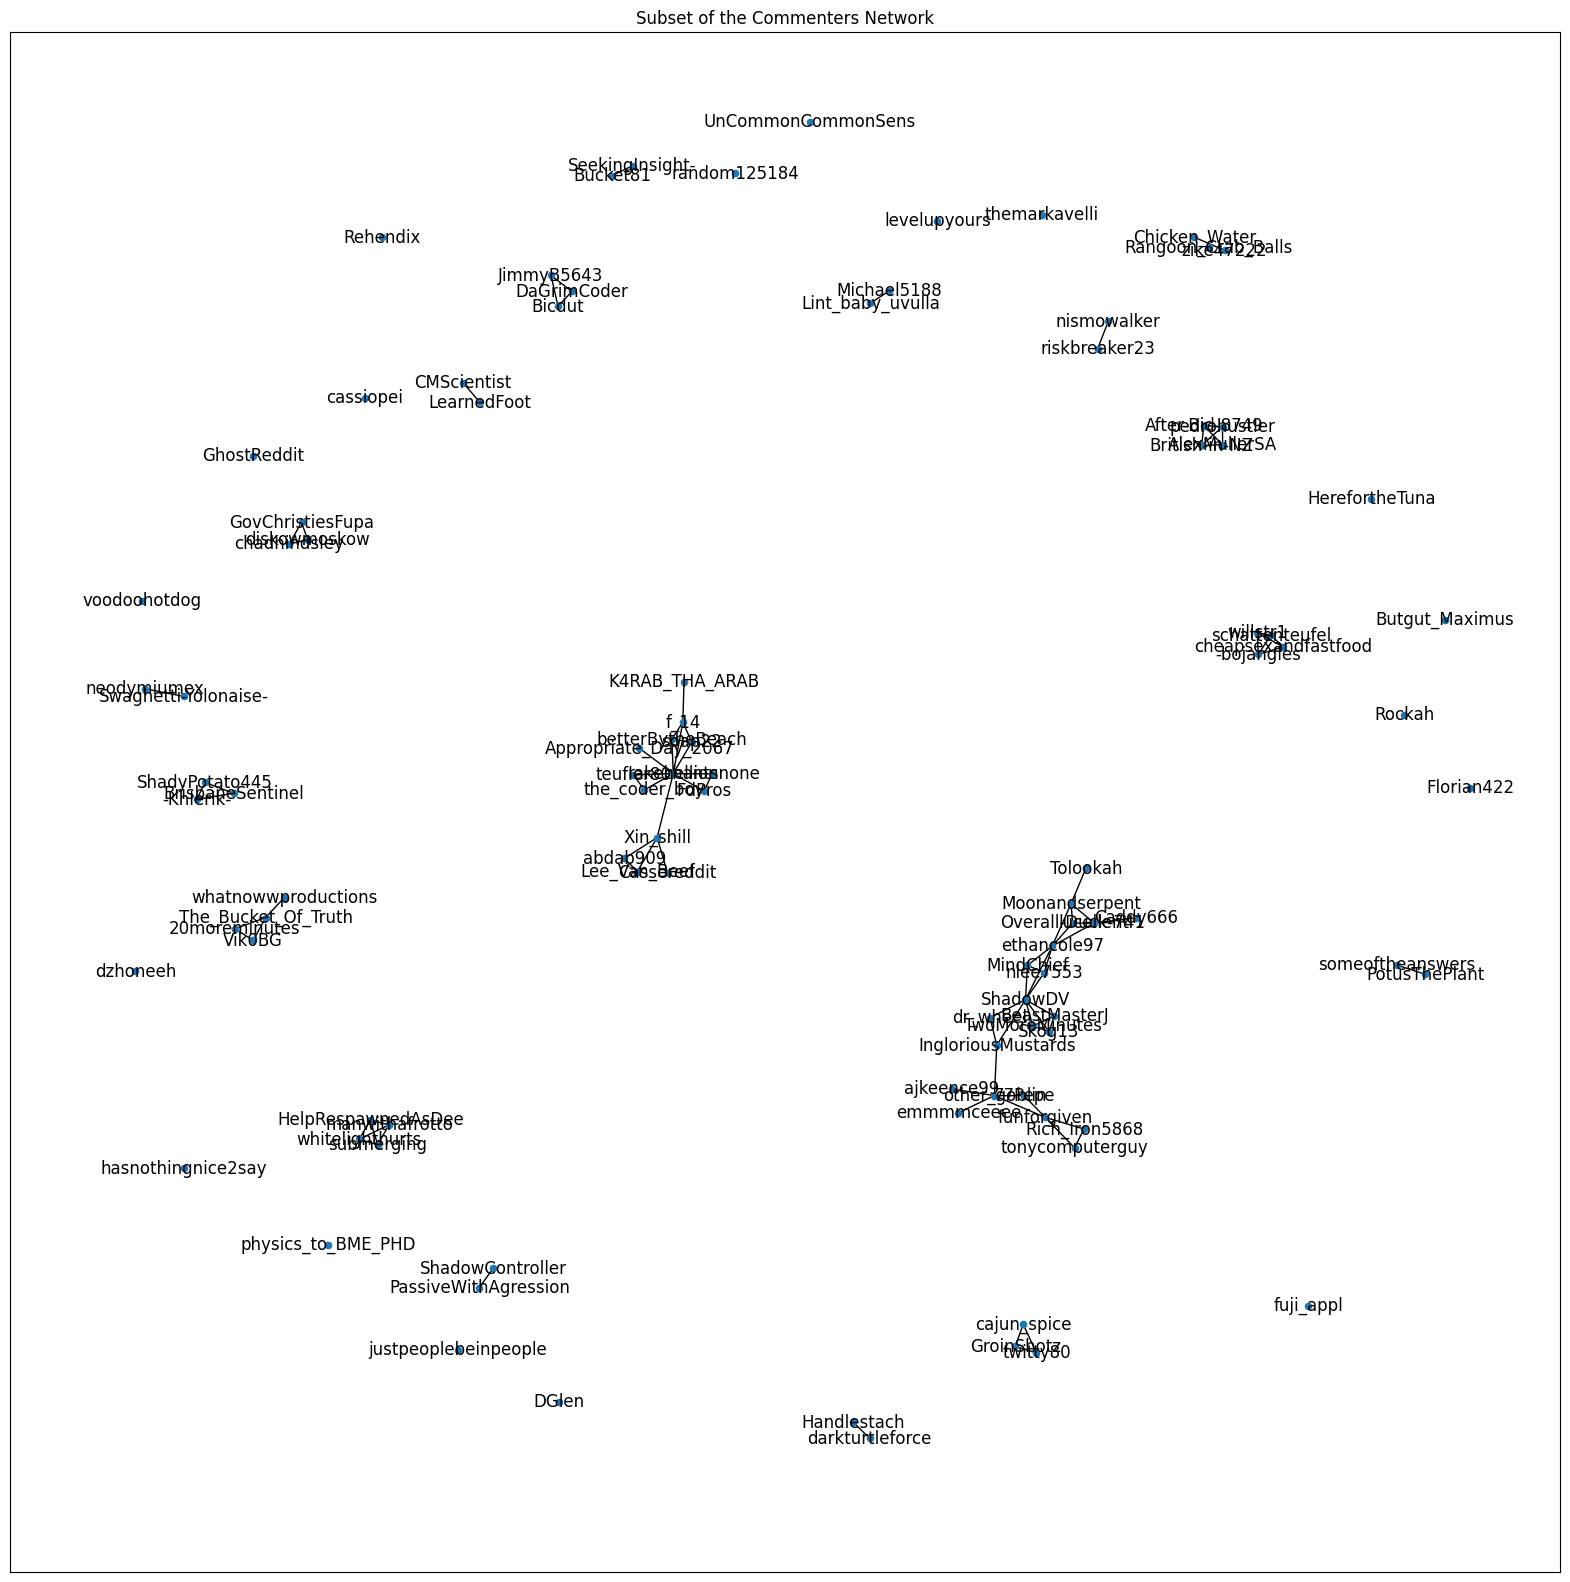

In [11]:
# Sample a subset of nodes from the graph
sampled_nodes = np.random.choice(G.nodes(), size=100, replace=False)

# Create a subgraph using the sampled nodes
subgraph = G.subgraph(sampled_nodes)

# Draw the network of the sampled commenters
plt.figure(figsize=(20, 20))
nx.draw_networkx(subgraph, with_labels=True, node_size=20, width=1)
plt.title("Subset of the Commenters Network")
plt.show()

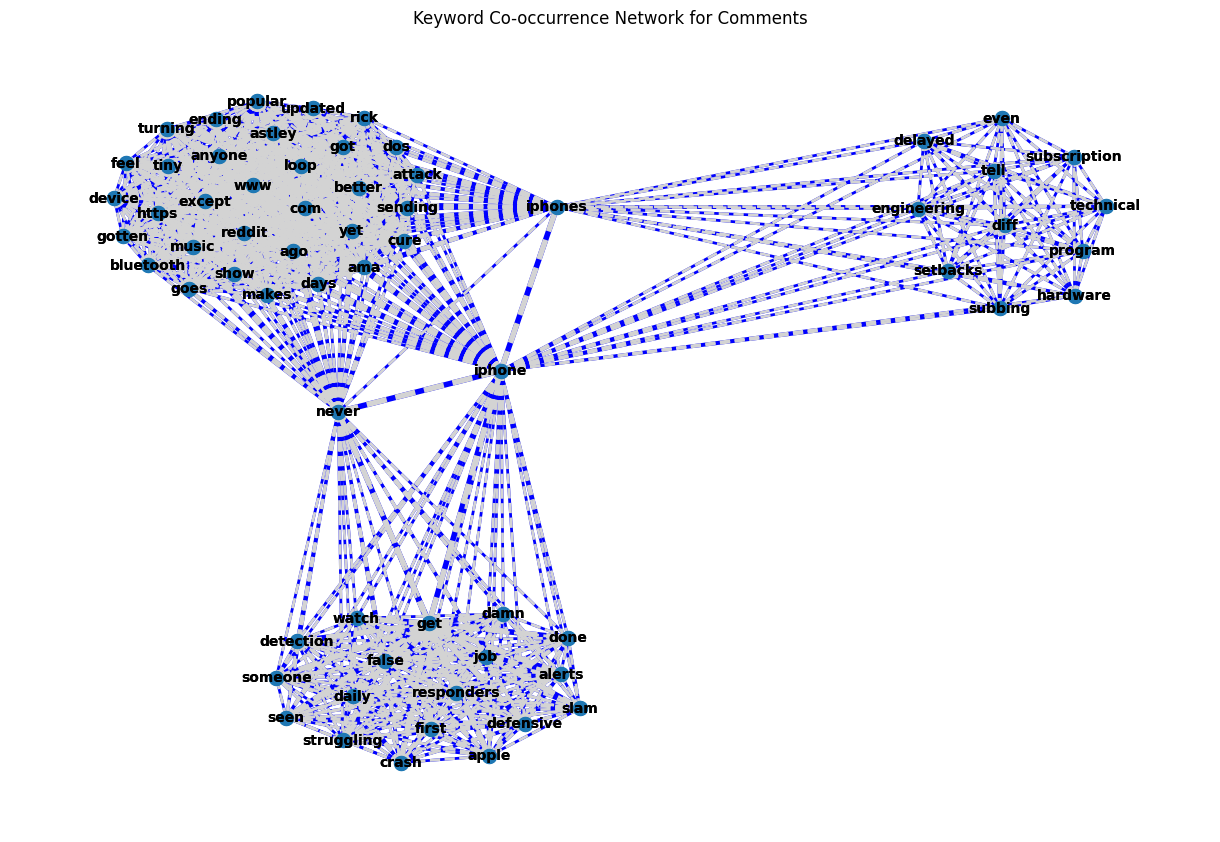

In [12]:
# Sample a subset of comments for analysis (adjust the sample size as needed)
sample_size = 3
sampled_comments_df = iphone_comments_df.sample(sample_size)

# Function to extract keywords from a comment and calculate co-occurrences
def process_comment(comment_tokens):
    co_occurrences = {}
    for keyword1 in comment_tokens:
        for keyword2 in comment_tokens:
            if keyword1 != keyword2:
                co_occurrences[(keyword1, keyword2)] = co_occurrences.get((keyword1, keyword2), 0) + 1
    return co_occurrences

# Create a graph network
G = nx.Graph()

# Create a list to store the results from parallel processing
results = []

# Use parallel processing to extract keywords and co-occurrences
with ProcessPoolExecutor(max_workers=4) as executor:  # Adjust the number of workers as needed
    results = executor.map(process_comment, sampled_comments_df['Tokens'])

# Process the results to update the graph
for result in results:
    for (keyword1, keyword2), co_occurrence_count in result.items():
        if G.has_edge(keyword1, keyword2):
            G[keyword1][keyword2]['weight'] += co_occurrence_count
        else:
            G.add_edge(keyword1, keyword2, weight=co_occurrence_count)

# Plot the graph network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
edge_colors = ['lightgray' for _ in range(len(G.edges()))]  # Define a list of light gray colors for edges

# Plot the network with solid lines
nx.draw(
    G, pos, node_size=100, font_size=10, with_labels=True, font_weight='bold',
    width=edge_weights, edge_color='blue'  # You can choose any color for solid lines
)

# Plot the network with dashed lines in a lighter color
nx.draw(
    G, pos, node_size=100, font_size=10, with_labels=True, font_weight='bold',
    width=edge_weights, edge_color=edge_colors, style='dashed'
)

plt.title('Keyword Co-occurrence Network for Comments')
plt.axis('off')
plt.show()

In [13]:
# Sample a subset of comments for analysis (adjust the sample size as needed)
sample_size = 20
sampled_comments_df = iphone_comments_df.sample(sample_size)

# Create a DataFrame to store keywords, authors, and upvotes
keyword_author_upvotes_df = sampled_comments_df[['Tokens', 'Author', 'Upvotes']].explode('Tokens')

# Create a graph network
G = nx.Graph()

# Add nodes (keywords and authors) to the graph
keywords = keyword_author_upvotes_df['Tokens'].unique()
authors = keyword_author_upvotes_df['Author'].unique()
for keyword in keywords:
    G.add_node(keyword, type='keyword')
for author in authors:
    G.add_node(author, type='author')

# Add weighted edges (connections between keywords and authors) based on upvotes
for _, row in keyword_author_upvotes_df.iterrows():
    keyword = row['Tokens']
    author = row['Author']
    upvotes = row['Upvotes']

    if G.has_edge(keyword, author):
        G[keyword][author]['weight'] += upvotes
    else:
        G.add_edge(keyword, author, weight=upvotes)

# Perform community detection using the Girvan-Newman algorithm
communities = list(nx.community.girvan_newman(G))

# Extract the largest community
largest_community = max(communities, key=len)

# Create a DataFrame to store keywords and their respective authors within the largest community
keyword_author_communities_df = pd.DataFrame(columns=['Keyword', 'Authors'])
for node_set in largest_community:
    for node in node_set:
        if G.nodes[node]['type'] == 'keyword':
            keyword = node
            authors = [neighbor for neighbor in G.neighbors(node) if G.nodes[neighbor]['type'] == 'author']
            keyword_author_communities_df = keyword_author_communities_df.append({'Keyword': keyword, 'Authors': authors}, ignore_index=True)

# Display the keyword-author communities DataFrame
print("Keyword-Author Communities:")
keyword_author_communities_df


Keyword-Author Communities:


Keyword                                            Authors
0            joe                                          [ben1481]
1          biden                                          [ben1481]
2          wants                                 [ben1481, UserID_]
3          apple  [ben1481, rdicky58, coludFF_h, ManlyDude1047, ...
4           free                                          [ben1481]
..           ...                                                ...
353    malicious                                          [UserID_]
354   compliance                                          [UserID_]
355        stuff                                          [UserID_]
356      keeping                                          [UserID_]
357  proprietary                                          [UserID_]

[358 rows x 2 columns]

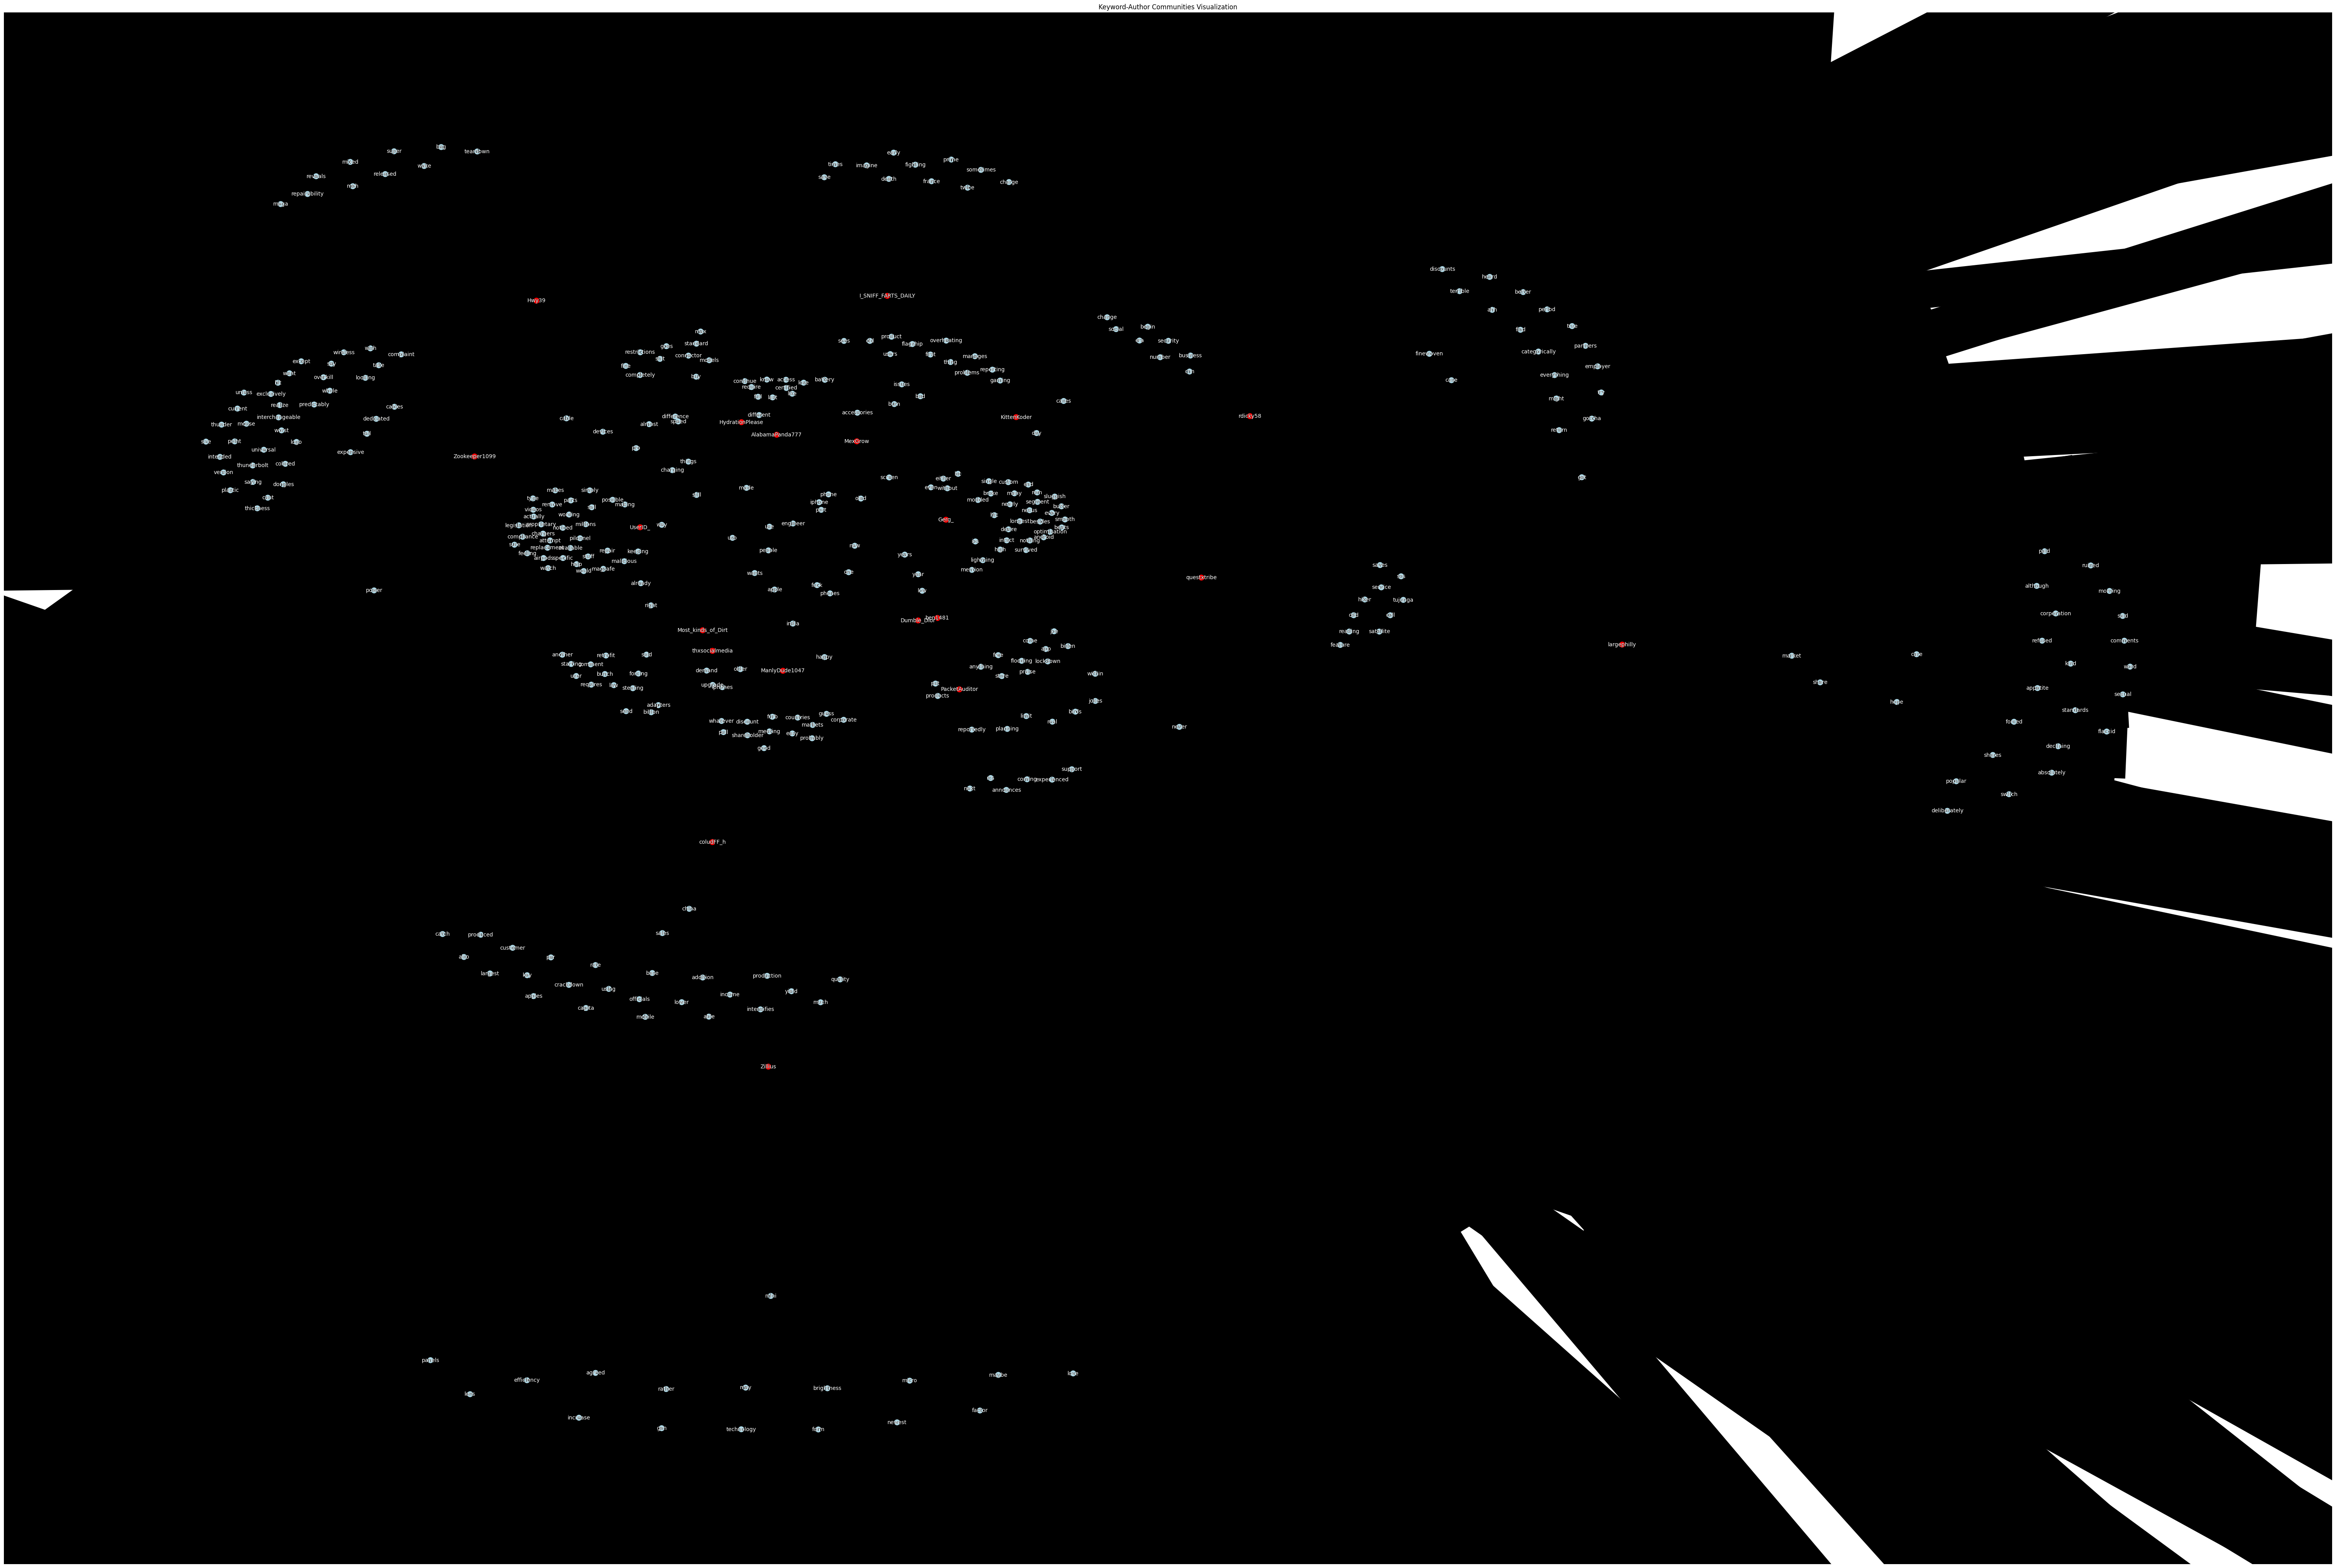

In [14]:
# Create a new graph network for visualization (to avoid modifying the original network)
visualization_G = nx.Graph()

# Add nodes (keywords and authors) to the visualization graph
for node in largest_community:
    for n in node:
        node_type = G.nodes[n]['type']
        visualization_G.add_node(n, type=node_type)

# Add edges based on the original network's edges (excluding nodes outside the largest community)
for u, v, data in G.edges(data=True):
    if u in visualization_G.nodes and v in visualization_G.nodes:
        visualization_G.add_edge(u, v, weight=data['weight'])

# Positioning of nodes
pos = nx.spring_layout(visualization_G, k=0.5)

# Draw the graph network
plt.figure(figsize=(60, 40))
node_types = [visualization_G.nodes[node]['type'] for node in visualization_G.nodes]

# Lighter colors for nodes
node_colors = ['lightblue' if node_type == 'keyword' else 'red' for node_type in node_types]

edge_weights = [visualization_G[u][v]['weight'] for u, v in visualization_G.edges()]
nx.draw(visualization_G, pos, node_size=100, font_size=10, with_labels=True, font_weight='bold',
        node_color=node_colors, width=edge_weights)

# Add labels to nodes
labels = {node: node for node in visualization_G.nodes}
nx.draw_networkx_labels(visualization_G, pos, labels=labels, font_size=10, font_color='white')

# Set the title and axis off
plt.title('Keyword-Author Communities Visualization')
plt.axis('off')

# Show the plot
plt.show()


Analysis of Conversation Clusters
Beeper1099
-   Topics: Seems to discuss technical aspects such as "type," "makes," "cable," "devices," "parts," "remove," and "actually." The mention of "videos" suggests multimedia content or tutorials might be part of the conversation.
-   Insights: This author may be focused on the technical specifications, types of cables and parts, or DIY aspects related to iPhones.
UserID_
-   Topics: Discusses "repair," "malicious," "MagSafe," and "help," along with "millions" and "stuff."
-   Insights: The conversation likely revolves around repairability, security concerns, or the utility of iPhone accessories like MagSafe.
Authors Near the Bottom (Most_kinds_of_Dirt, Dumble_Dior, ben_1481)
-   Topics: The discussion centers on "India," "Apple," "phone," "wants," "people," "use," "engineer," "low," "year."
-   Insights: These authors might be discussing Apple's presence in India, engineering aspects, user desires, affordability, and product lifecycle.
Authors at the Top (HydrationPlease, AlabamaPanda777, MexGrow)
-   Topics: They are associated with terms like "difference speed," "accessories," "battery," "screen," "ports," "made," "models," "connectors."
-   Insights: This group seems to focus on the performance of the iPhone, its components like batteries and screens, and perhaps issues or preferences regarding models and manufacturing details.
KittenKoder
-   Topics: Comments on "gaming," "reporting," "problems," "managing," "things," "cases," "custom made," "evergreen."
-   Insights: KittenKoder's conversation might be around gaming performance on iPhones, problem reporting, case management, and possibly the longevity or sustainability of devices.
Greg_
-   Topics: Talks about "mobile," "desire," "intact," "mention," "serviced," "android," "optimization," "segment," "smooth."
-   Insights: Greg_ is potentially discussing comparative aspects of iPhone versus Android, focusing on performance optimization and user experience.
General Insights
-   Technical Specifications: There's a notable discussion around the physical and technical aspects of the iPhone, such as parts and accessories.
-   Repair and Security: Repairability, security concerns, and the functionality of features like MagSafe are significant to these users.


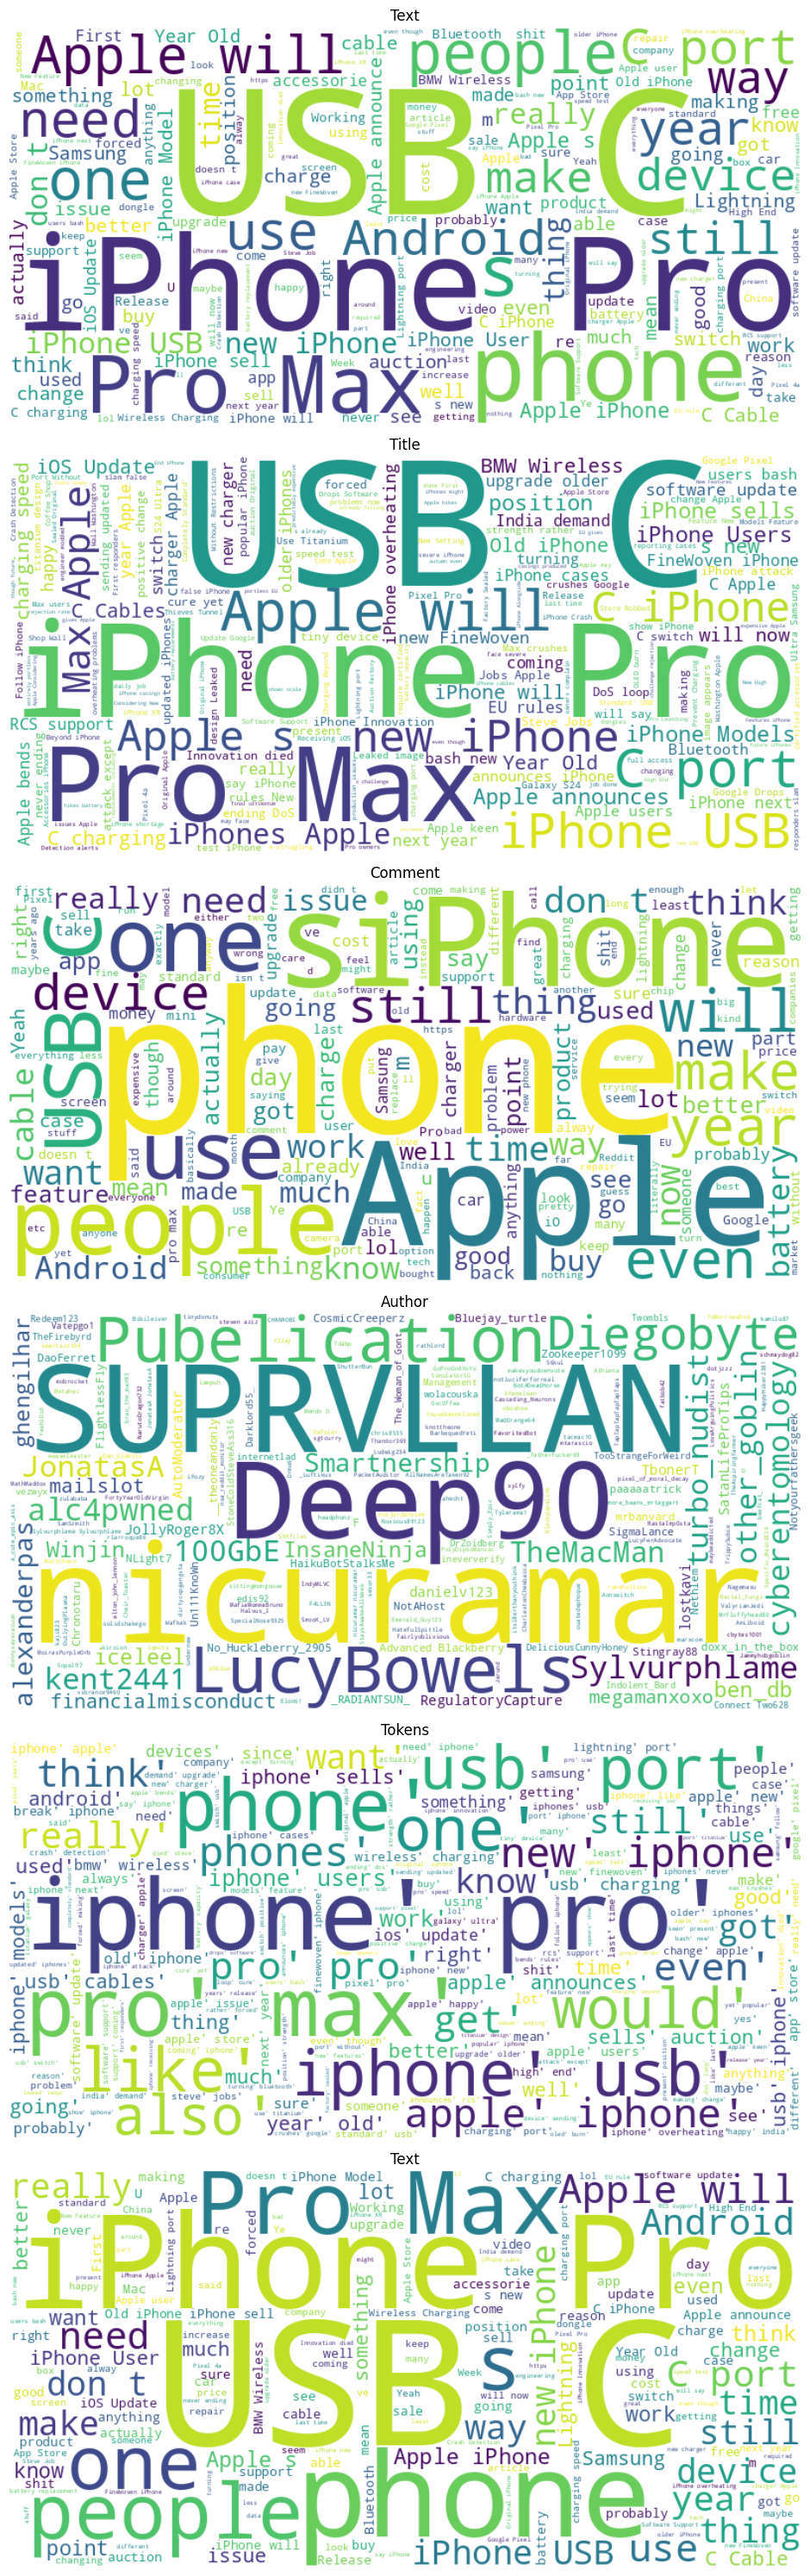

In [15]:
columns_to_visualize = ['Text', 'Title', 'Comment', 'Author', 'Tokens', 'Text']

# Set up subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(50, 30))
axes = axes.flatten()

for i, column in enumerate(columns_to_visualize):
    # Concatenate all words in the specified column
    words = ' '.join(iphone_comments_df[column].astype(str))

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(words)

    # Plot the WordCloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(column)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

- Device Models: The prominence of words like "Max" and "Pro" suggests that there is significant discussion around the higher-end models of the iPhone, which often come with more advanced features.
Features and Specifications: "USB" is quite prominent, likely referring to the type of charging port or connectivity options. The term "Bluetooth" also stands out, which is an essential wireless connectivity feature.
"Port," "charging," "wireless," and "cable" indicate a focus on how the device is charged and connected to other devices or accessories.
User Experience: Words like "use," "need," "make," "work," and "support" reflect the practical and functional aspects of the iPhone that users are concerned with.
Comparisons: There are comparisons being made between "Apple" and "Android," suggesting debates or discussions about the operating systems, user experience, or brand loyalty.
Market and Sales: The presence of words like "sell," "sales," "buy," and "new" indicates discussions around purchasing decisions, product launches, and the commercial aspects of the iPhone.
Updates and Support: "Update" and "support" imply conversations about the software aspect of the devices, possibly regarding iOS updates and Apple's after-sales support.
Community and Opinions: "People" and "user" highlight the community aspect of the discussions, emphasizing personal experiences and opinions.



- Product Usage: Words like "use," "device," "work," and "feature" suggest that the conversations revolve around how people are using their iPhones, the functionality of the devices, and the specific features they find significant or lacking.
Consumer Sentiment: Terms such as "need," "want," "buy," and "cost" highlight the consumer sentiment aspect, reflecting what consumers feel they require from their devices and their purchasing decisions.
Technical Aspects: "Cable," "update," "system," "mini," "port," and "charge" likely pertain to the technical and hardware aspects of iPhones. There could be discussions around charging methods, port types, software updates, and system performance.
Comparative Discussion: The presence of "Android" along with "Apple" implies a comparison between the two operating systems or perhaps between iPhones and Android devices in general.
- Community and Authors: The prominent display of usernames such as "SUPRVLLAN," "Deep90," "LucyBowels," "Sylvurphlame," among others, suggests that these individuals are particularly active or influential in discussions about the iPhone. Their prominence in the word cloud indicates they could be key opinion leaders or prolific contributors in the community.



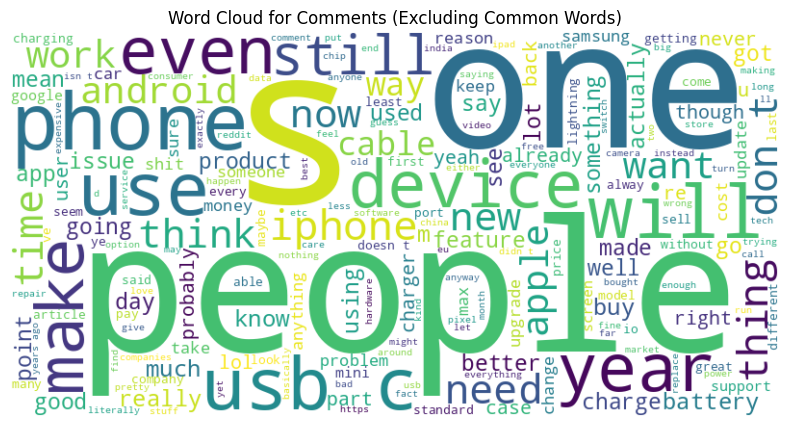

In [16]:
title_column = 'Comment'

# Create a list of common words to exclude
exclude_words = ['iphone', 'phone', 'pro', 'apple', 'C', 'S']

# Remove common words and convert titles to a space-separated string
filtered_comments = ' '.join(iphone_comments_df[title_column].apply(lambda comment: ' '.join([word for word in comment.lower().split() if word not in exclude_words])))

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(filtered_comments)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Comments (Excluding Common Words)')
plt.axis('off')
plt.show()

In [18]:
iphone_comments_df

Post_ID                                              Title  \
0      11283q1  50% rejection rate for iPhone casings produced...   
1      11283q1  50% rejection rate for iPhone casings produced...   
2      11283q1  50% rejection rate for iPhone casings produced...   
3      11283q1  50% rejection rate for iPhone casings produced...   
4      11283q1  50% rejection rate for iPhone casings produced...   
...        ...                                                ...   
30145  11e67uz  iPhone 16 Pro Still on Track to Feature Under-...   
30146  11e67uz  iPhone 16 Pro Still on Track to Feature Under-...   
30147  11e67uz  iPhone 16 Pro Still on Track to Feature Under-...   
30148  11e67uz  iPhone 16 Pro Still on Track to Feature Under-...   
30149  11e67uz  iPhone 16 Pro Still on Track to Feature Under-...   

                                                 Comment           Author  \
0      Atleast the quality control is still there ins...     sonbarington   
1      Chinese manufacturers can make you anything yo...        55_peters   
2      I know many people who have managed remote sof...  EmperorOfCanada   
3      This will always be the problem with shipping ...     bitwarrior80   
4      I wonder what the rejection rate was in China ...     Sethmeisterg   
...                                                  ...              ...   
30145  I loved the button/sensor on the back of by g6...           Datkif   
30146  With deepfakes, I would worry about voice ID\n...     What-a-Crock   
30147               Doesn’t FaceId have a mask mode now?       SmurphsLaw   
30148  Yeah I had it on my s8. Super fast and the pla...  snozzcumbersoup   
30149  I mean people have already been able to trick ...         DevoidHT   

       Upvote_ratio  Score  Upvotes  \
0              0.93  22658    22658   
1              0.93  22658    22658   
2              0.93  22658    22658   
3              0.93  22658    22658   
4              0.93  22658    22658   
...             ...    ...      ...   
30145          0.80    145      145   
30146          0.80    145      145   
30147          0.80    145      145   
30148          0.80    145      145   
30149          0.80    145      145   

                                                    Text  \
0      50% rejection rate for iPhone casings produced...   
1      50% rejection rate for iPhone casings produced...   
2      50% rejection rate for iPhone casings produced...   
3      50% rejection rate for iPhone casings produced...   
4      50% rejection rate for iPhone casings produced...   
...                                                  ...   
30145  iPhone 16 Pro Still on Track to Feature Under-...   
30146  iPhone 16 Pro Still on Track to Feature Under-...   
30147  iPhone 16 Pro Still on Track to Feature Under-...   
30148  iPhone 16 Pro Still on Track to Feature Under-...   
30149  iPhone 16 Pro Still on Track to Feature Under-...   

                                                  Tokens  
0      [rejection, rate, iphone, casings, produced, i...  
1      [rejection, rate, iphone, casings, produced, i...  
2      [rejection, rate, iphone, casings, produced, i...  
3      [rejection, rate, iphone, casings, produced, i...  
4      [rejection, rate, iphone, casings, produced, i...  
...                                                  ...  
30145  [iphone, pro, still, track, feature, display, ...  
30146  [iphone, pro, still, track, feature, display, ...  
30147  [iphone, pro, still, track, feature, display, ...  
30148  [iphone, pro, still, track, feature, display, ...  
30149  [iphone, pro, still, track, feature, display, ...  

[27940 rows x 9 columns]

In [19]:
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis on the entire 'Comment' column
iphone_comments_df['Sentiment'] = iphone_comments_df['Comment'].apply(calculate_sentiment)

# Add a column for sentiment category
iphone_comments_df['Sentiment_Category'] = np.where(iphone_comments_df['Sentiment'] >= 0.05, 'Positive',
                                                     np.where(iphone_comments_df['Sentiment'] <= -0.05, 'Negative', 'Neutral'))

# Count the number of each sentiment category
sentiment_counts = pd.value_counts(iphone_comments_df['Sentiment_Category'])
sentiment_counts

Positive    12597
Neutral     10310
Negative     5033
Name: Sentiment_Category, dtype: int64

In [20]:
# Subdataset 1: Author, Sentiment, Title
subdataset_1 = iphone_comments_df[['Author', 'Sentiment_Category', 'Title']].copy()

# Subdataset 2: Author, Sentiment, Comment
subdataset_2 = iphone_comments_df[['Author', 'Sentiment_Category', 'Comment']].copy()

# Subdataset 3: Title, Sentiment, List of Authors
subdataset_3 = iphone_comments_df.groupby(['Title', 'Sentiment_Category'])['Author'].unique().reset_index()
subdataset_3['Authors_List'] = subdataset_3['Author'].apply(lambda x: ', '.join(x))

titles_data = subdataset_3['Title'].tolist()

# Preprocess the titles by removing stop words and tokenizing
stop_words = set(stopwords.words('english'))

tokenized_titles = [
    [word.lower() for word in word_tokenize(title) if word.isalpha() and word.lower() not in stop_words]
    for title in titles_data
]

# Create a dictionary representation of the titles
dictionary = corpora.Dictionary(tokenized_titles)

# Convert the titles into a bag-of-words representation
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_titles]

# Build the LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Print the topics and associated words
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.082*"iphone" + 0.041*"pro" + 0.037*"apple" + 0.021*"new" + 0.013*"max"')
(1, '0.082*"iphone" + 0.054*"apple" + 0.018*"new" + 0.014*"charging" + 0.014*"radiation"')
(2, '0.079*"iphone" + 0.040*"apple" + 0.032*"users" + 0.016*"update" + 0.016*"satellite"')
(3, '0.108*"iphone" + 0.057*"pro" + 0.033*"apple" + 0.029*"max" + 0.017*"feature"')
(4, '0.056*"apple" + 0.056*"iphone" + 0.041*"iphones" + 0.011*"india" + 0.011*"charging"')


Develop content pillars around the five topics identified by the LDA model:
- Topic 0 and 3 (Pro and Max Models): Create feature spotlights and comparison content that showcases the advantages of the Pro and Max models over previous versions or competitors.
- 	Topic 1 (Charging and Radiation): Provide clear communication about the safety and efficiency of the iPhone's charging technology. Debunk myths and provide facts about radiation levels.
- 	Topic 2 (User Updates and Satellite): Highlight the latest software updates and how they improve user experience. Also, provide sneak peeks or educational content on emerging technologies like satellite connectivity.
- 	Topic 4 (Market Focus - India): Tailor content for specific markets such as India to connect with the audience there. Share stories of local impact and relevance.


In [21]:
# Subdataset 4: Title, Sentiment, List of Authors, Sentiment Total
subdataset_4 = iphone_comments_df.groupby(['Title', 'Author', 'Sentiment', 'Sentiment_Category'])['Sentiment'].sum().reset_index(name='Sentiment_Total')

# Map sentiment scores to categories (positive = +1, negative = -1, neutral = 0)
subdataset_4['Sentiment_Total'] = subdataset_4['Sentiment_Total'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

sub_dataset_4 = iphone_comments_df.groupby(['Title', 'Sentiment_Category']).agg({'Author': 'unique', 'Comment': 'count', 'Sentiment': 'sum'}).reset_index()
sub_dataset_4['Sentiment_Total'] = sub_dataset_4['Sentiment'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

master_comments_list = iphone_comments_df.groupby('Title')['Comment'].apply(lambda x: ' '.join(x)).reset_index()
sub_dataset_4 = pd.merge(sub_dataset_4, master_comments_list, on='Title', how='left', suffixes=('', '_master_comments'))
sub_dataset_4 = sub_dataset_4.sort_values(by='Sentiment', ascending=True)
sub_dataset_4

Title Sentiment_Category  \
33   Apple iPhone 15 Pro Max users are reporting ca...           Negative   
275  iPhone 15 to require certified accessories for...           Negative   
39   Apple isn't happy about India's demand to upgr...           Negative   
72   Apple will issue a software update to address ...           Negative   
155  Leaked image appears to show iPhone 15 Pro wit...           Negative   
..                                                 ...                ...   
35   Apple iPhone 15 Pro Max users are reporting ca...           Positive   
38   Apple is changing the charging port with iPhon...           Positive   
178            No, you really don't need the iPhone 15           Positive   
65   Apple users bash new iPhone 15: ‘Innovation di...           Positive   
262  iPhone 15 Pro Max crushes Google Pixel 8 Pro i...           Positive   

                                                Author  Comment  Sentiment  \
33   [dxin, Blapanda, Blocky_Master, SuppleDude, So...      108 -26.522864   
275  [imakenosensetopeople, FurryWolves, IQBoosterS...       95 -25.424230   
39   [popswag, johnnyg883, Beautiful-Hunter8895, Na...       97 -25.377162   
72   [OperatorJo_, sahils88, dr34mc4st3r, thinkfirs...       91 -25.316873   
155  [dotcomslashwhatever, JCreazy, Paristocrat, Ho...       81 -25.024022   
..                                                 ...      ...        ...   
35   [AutoModerator, ajphx, bitNine, DarthAK47, Avi...      193  60.218866   
38   [AutoModerator, jradio, ze_baco, Blurgas, kham...      223  63.084067   
178  [PM_ME_YOUR__INIT__, spiralshapegladiator, -Ad...      238  63.982813   
65   [bigersmaler, igby1, MyIncogName, TrollBot007,...      240  65.265289   
262  [SLJ7, Ragnaroknight, someNameThisIs, meat_pop...      243  71.531264   

     Sentiment_Total                            Comment_master_comments  
33                -1  \nWe have a giveaway running, be sure to enter...  
275               -1  From the article: According to a rumor, Apple ...  
39                -1  From the article: Apple has urged the Indian I...  
72                -1  Every photo of this guy and he's doing this po...  
155               -1  Yes. Now my iPad and iPhone can use one cord! ...  
..               ...                                                ...  
35                 1  \nWe have a giveaway running, be sure to enter...  
38                 1  \nWe have a giveaway running, be sure to enter...  
178                1  You don't need Phone Brand N. But if you're on...  
65                 1  LOL 1 The New York Post is reporting message b...  
262                1  I like my phone and I hope you like yours. I m...  

[305 rows x 7 columns]

In [22]:
# Extract top 5 negative and positive comments
top_negative_comments = sub_dataset_4.head(5)['Comment_master_comments']
top_positive_comments = sub_dataset_4.tail(5)['Comment_master_comments']

# Combine top 5 negative and positive comments into single comments
combined_negative_comment = ' '.join(top_negative_comments)
combined_positive_comment = ' '.join(top_positive_comments)

# Function to summarize text using LSA algorithm
def summarize_text(text, sentences_count=4):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return ' '.join(str(sentence) for sentence in summary)

# Summarize combined negative and positive comments
summary_negative = summarize_text(combined_negative_comment)
summary_positive = summarize_text(combined_positive_comment)

# Display the summaries
print("Top 5 Negative Comments Summary:")
print(summary_negative)

print("\nTop 5 Positive Comments Summary:")
print(summary_positive)

Top 5 Negative Comments Summary:
Its really far too soon to be real  burn in unless the panels are just not made correctly can't get any more modern and forward looking than a 3D Apple logo marquee. So still have to bring a cable wherever I go, can't even be part of the universal USB-C community Anybody who’s surprised at this hasn’t been paying attention. It's not like we didn't see Google release a whole separate version of Android just to run on cheaper lower end hardware so they could sell more phones in india. Remember how apple was promoting environment saving by not including the charger but God forbid they could have made an iPhone that didn't need a different cable from every other universal product using usb c.

Top 5 Positive Comments Summary:
Its really far too soon to be real  burn in unless the panels are just not made correctly can't get any more modern and forward looking than a 3D Apple logo marquee. Thanks for making me spit coffee all over my keyboard Yeah the bigges

In [25]:
# sub_dataset_4.to_csv('iphone subset data with 7 coumns.csv', index=False)
# iphone_comments_df.to_csv('iphone data main.csv', index=False)

In [31]:
iphone_comments_df.columns

Index(['Post_ID', 'Title', 'Comment', 'Author', 'Upvote_ratio', 'Score',
       'Upvotes', 'Text', 'Tokens', 'Sentiment', 'Sentiment_Category'],
      dtype='object')

In [26]:
sub_dataset_4.columns

Index(['Title', 'Sentiment_Category', 'Author', 'Comment', 'Sentiment',
       'Sentiment_Total', 'Comment_master_comments'],
      dtype='object')

In [30]:
sub_dataset_4

Title Sentiment_Category  \
33   Apple iPhone 15 Pro Max users are reporting ca...           Negative   
275  iPhone 15 to require certified accessories for...           Negative   
39   Apple isn't happy about India's demand to upgr...           Negative   
72   Apple will issue a software update to address ...           Negative   
155  Leaked image appears to show iPhone 15 Pro wit...           Negative   
..                                                 ...                ...   
35   Apple iPhone 15 Pro Max users are reporting ca...           Positive   
38   Apple is changing the charging port with iPhon...           Positive   
178            No, you really don't need the iPhone 15           Positive   
65   Apple users bash new iPhone 15: ‘Innovation di...           Positive   
262  iPhone 15 Pro Max crushes Google Pixel 8 Pro i...           Positive   

                                                Author  Comment  Sentiment  \
33   [dxin, Blapanda, Blocky_Master, SuppleDude, So...      108 -26.522864   
275  [imakenosensetopeople, FurryWolves, IQBoosterS...       95 -25.424230   
39   [popswag, johnnyg883, Beautiful-Hunter8895, Na...       97 -25.377162   
72   [OperatorJo_, sahils88, dr34mc4st3r, thinkfirs...       91 -25.316873   
155  [dotcomslashwhatever, JCreazy, Paristocrat, Ho...       81 -25.024022   
..                                                 ...      ...        ...   
35   [AutoModerator, ajphx, bitNine, DarthAK47, Avi...      193  60.218866   
38   [AutoModerator, jradio, ze_baco, Blurgas, kham...      223  63.084067   
178  [PM_ME_YOUR__INIT__, spiralshapegladiator, -Ad...      238  63.982813   
65   [bigersmaler, igby1, MyIncogName, TrollBot007,...      240  65.265289   
262  [SLJ7, Ragnaroknight, someNameThisIs, meat_pop...      243  71.531264   

     Sentiment_Total                            Comment_master_comments  
33                -1  \nWe have a giveaway running, be sure to enter...  
275               -1  From the article: According to a rumor, Apple ...  
39                -1  From the article: Apple has urged the Indian I...  
72                -1  Every photo of this guy and he's doing this po...  
155               -1  Yes. Now my iPad and iPhone can use one cord! ...  
..               ...                                                ...  
35                 1  \nWe have a giveaway running, be sure to enter...  
38                 1  \nWe have a giveaway running, be sure to enter...  
178                1  You don't need Phone Brand N. But if you're on...  
65                 1  LOL 1 The New York Post is reporting message b...  
262                1  I like my phone and I hope you like yours. I m...  

[305 rows x 7 columns]

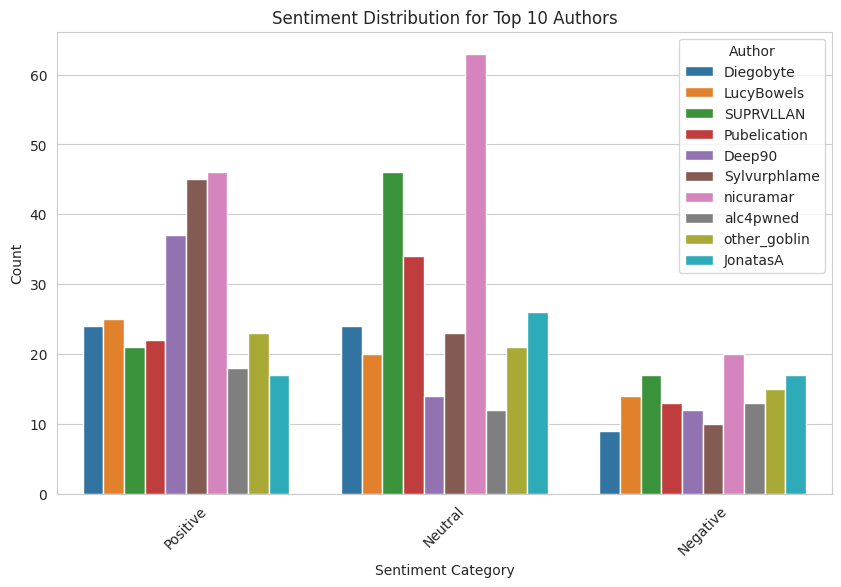

In [32]:
# Get the top 10 authors by comment count
top_10_authors = iphone_comments_df['Author'].value_counts().head(10)

# Create a new DataFrame to store the sentiment distribution for these authors
author_sentiment_distribution = iphone_comments_df[iphone_comments_df['Author'].isin(top_10_authors.index)]

# Plot the distribution of sentiment categories for the top 10 authors
plt.figure(figsize=(10, 6))
sns.countplot(data=author_sentiment_distribution, x='Sentiment_Category', hue='Author', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution for Top 10 Authors')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Author', loc='upper right')
plt.show()

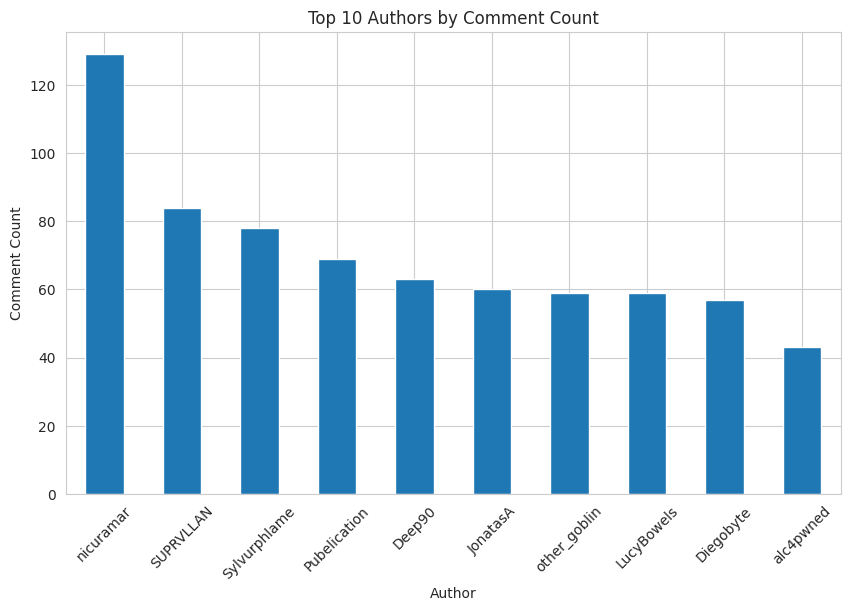

In [33]:
# Author Contribution
author_comment_counts = iphone_comments_df['Author'].value_counts().head(10)
plt.figure(figsize=(10, 6))
author_comment_counts.plot(kind='bar')
plt.title('Top 10 Authors by Comment Count')
plt.xlabel('Author')
plt.ylabel('Comment Count')
plt.xticks(rotation=45)
plt.show()

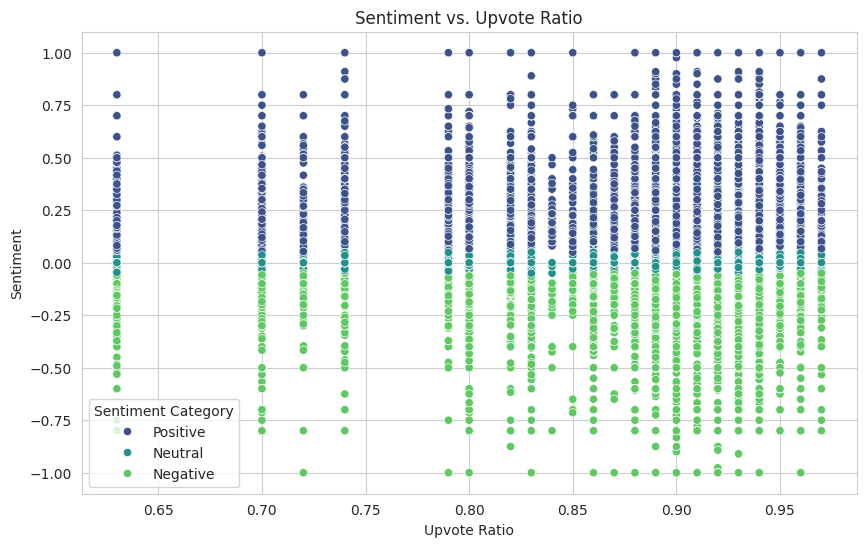

In [34]:
# Sentiment Over Upvote Ratio (Scatter Plot):

plt.figure(figsize=(10, 6))
sns.scatterplot(data=iphone_comments_df, x='Upvote_ratio', y='Sentiment', hue='Sentiment_Category', palette='viridis')
plt.title('Sentiment vs. Upvote Ratio')
plt.xlabel('Upvote Ratio')
plt.ylabel('Sentiment')
plt.legend(title='Sentiment Category')
plt.show()

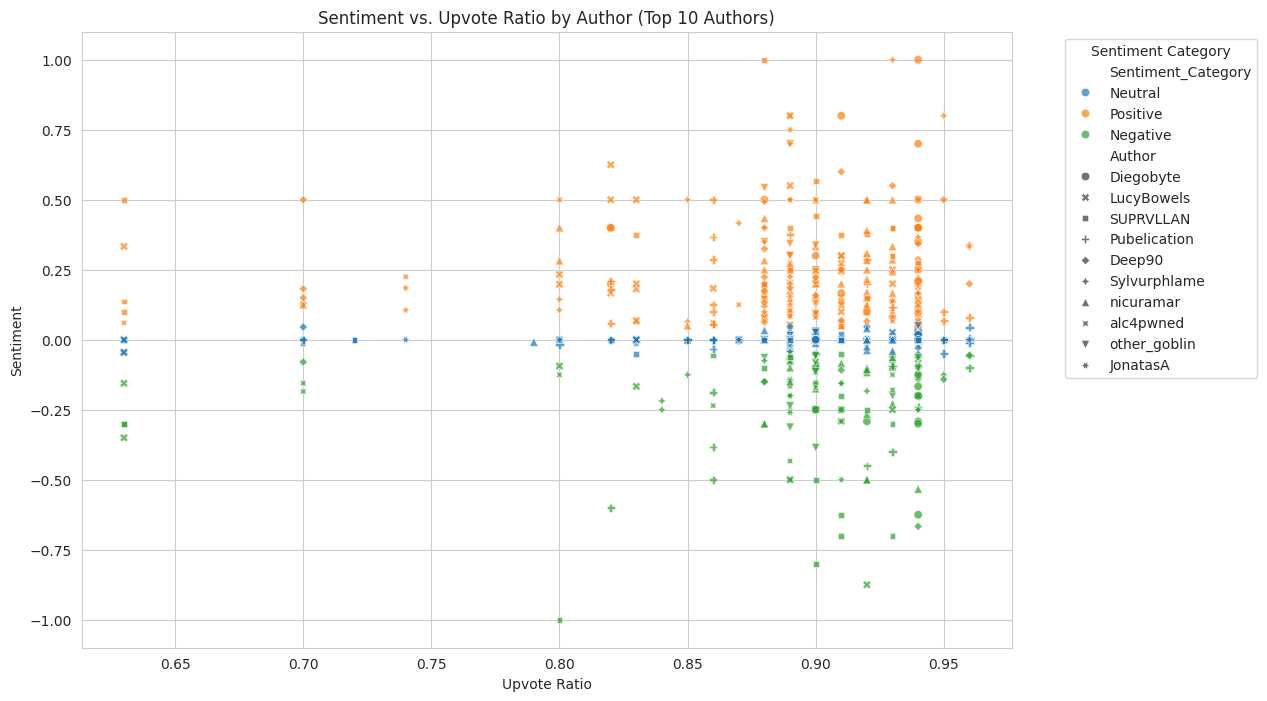

In [41]:
# scatter plot that displays the sentiment on the y-axis, upvote ratio on the x-axis, and different authors represented by different markers. The hue of the markers represents the sentiment category.

# Limit data to a smaller subset of authors top 10 authors,
top_10_authors = iphone_comments_df['Author'].value_counts().head(10)
filtered_data = iphone_comments_df[iphone_comments_df['Author'].isin(top_10_authors.index)]

# Increase the size of the plot
plt.figure(figsize=(12, 8))

# Create the scatter plot
scatter_plot = sns.scatterplot(data=filtered_data, x='Upvote_ratio', y='Sentiment', hue='Sentiment_Category', style='Author', markers=True, alpha=0.7)

# Move the legend outside of the chart
plt.legend(title='Sentiment Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Sentiment vs. Upvote Ratio by Author (Top 10 Authors)')
plt.xlabel('Upvote Ratio')
plt.ylabel('Sentiment')

plt.show()